In [ ]:
!pip install nengo

In [2]:
import nengo
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report

In [3]:
class Dataset:
  def __init__(self, time_per_data, x_data=None, y_data=None):
    self.x_data = x_data
    self.y_data = y_data
    self.time_per_data = time_per_data

  def set_dataset(self, x_data, y_data):
    self.x_data = x_data
    self.y_data = y_data

  def get_x(self, t):
    idx = int(t//self.time_per_data) % len(self.x_data)
    return self.x_data[idx]

  def get_y(self, t):
    idx = int(t//self.time_per_data) % len(self.y_data)
    return self.y_data[idx]

In [4]:
time_per_data = 0.1
duration = 10.0
standard = 0.0

model = nengo.Network()
with model:
  x_data = np.random.uniform(-50, 50, 100)
  y_data = np.eye(2)[(x_data>standard).astype(np.int32)]

  dataset = Dataset(time_per_data, x_data, y_data)

  input_node = nengo.Node(dataset.get_x, size_out=1)
  target_node = nengo.Node(dataset.get_y, size_out=2)
  input = nengo.Ensemble(100, 1)
  target = nengo.Ensemble(100, 2)

  nengo.Connection(input_node, input)
  nengo.Connection(target_node, target)

  pred = nengo.Ensemble(200, 2)
  pred_conn = nengo.Connection(input, pred, transform=[[1], [1]])

  input_node_p = nengo.Probe(input_node, synapse=0.01)
  target_node_p = nengo.Probe(target_node, synapse=0.01)
  input_p = nengo.Probe(input, synapse=0.01)
  pred_p = nengo.Probe(pred, synapse=0.01)
  target_p = nengo.Probe(target, synapse=0.01)

In [5]:
with nengo.Simulator(model) as sim:
  sim.run(duration)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

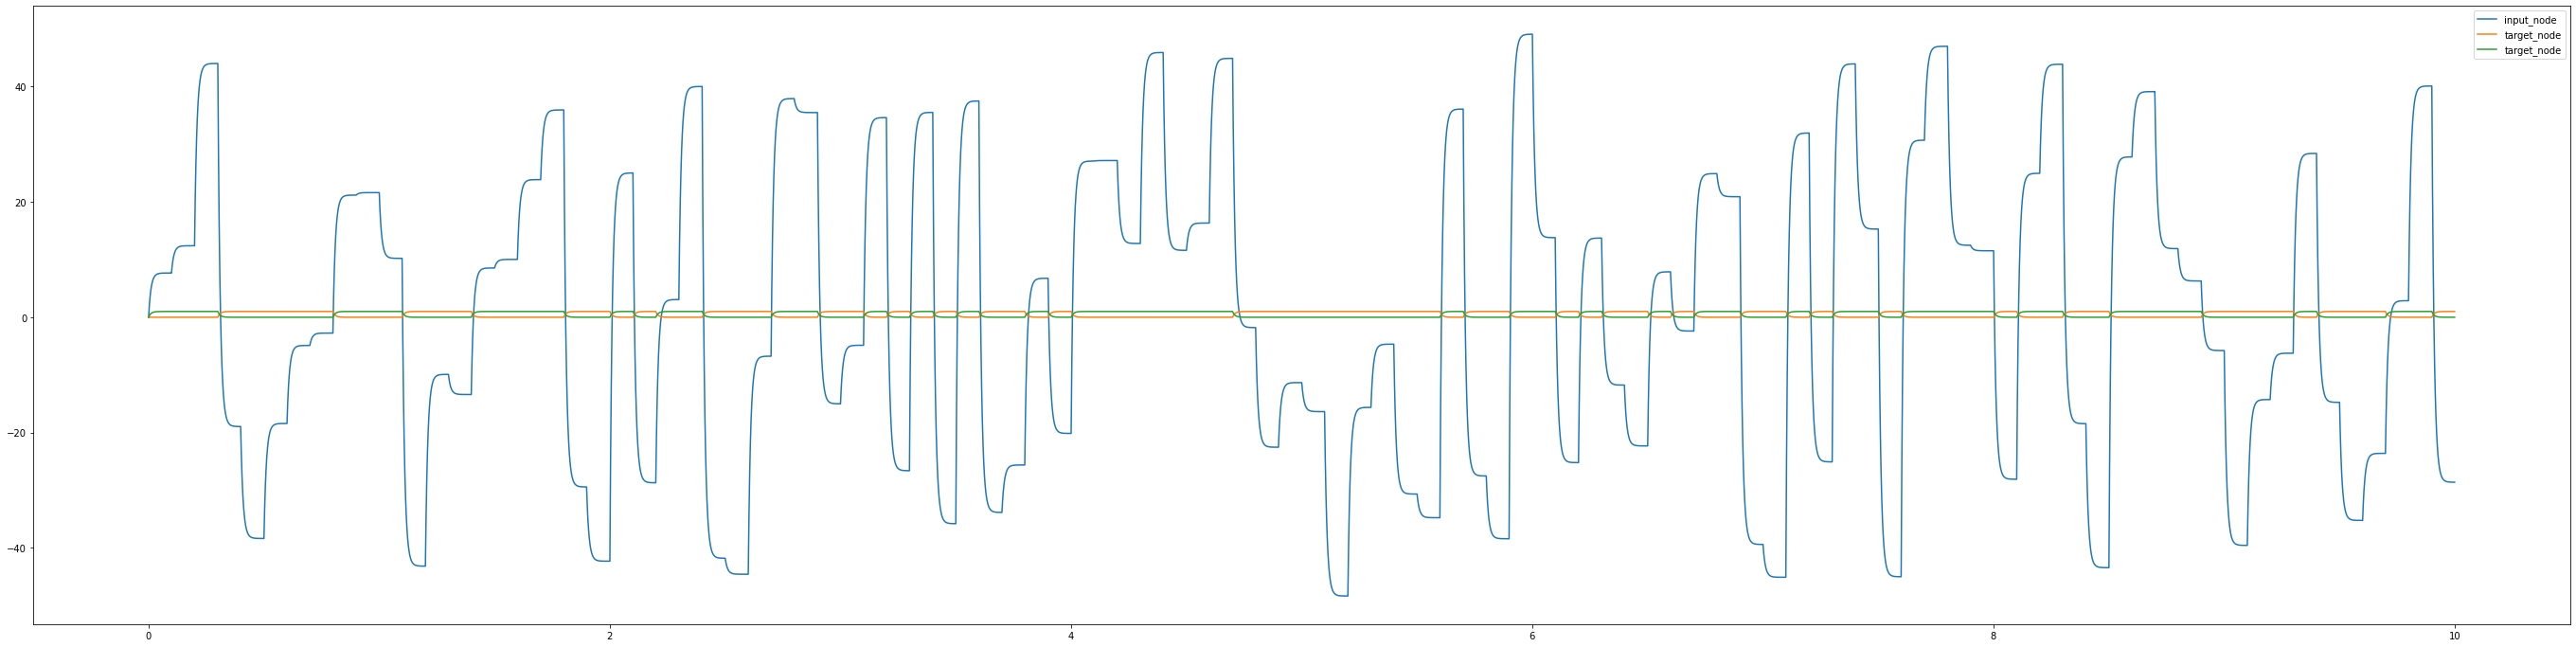

In [6]:
plt.figure(figsize=(48, 12))
plt.plot(sim.trange(), sim.data[input_node_p], label="input_node")
plt.plot(sim.trange(), sim.data[target_node_p], label="target_node")
plt.legend()
plt.show()

# Train

In [7]:
with model:
  err = nengo.Ensemble(200, dimensions=2)
  nengo.Connection(pred, err)
  nengo.Connection(target, err, transform=-1)

  pred_conn.learning_rule_type = nengo.learning_rules.PES()
  nengo.Connection(err, pred_conn.learning_rule)  

In [8]:
with nengo.Simulator(model) as sim:
    sim.run(10.0)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

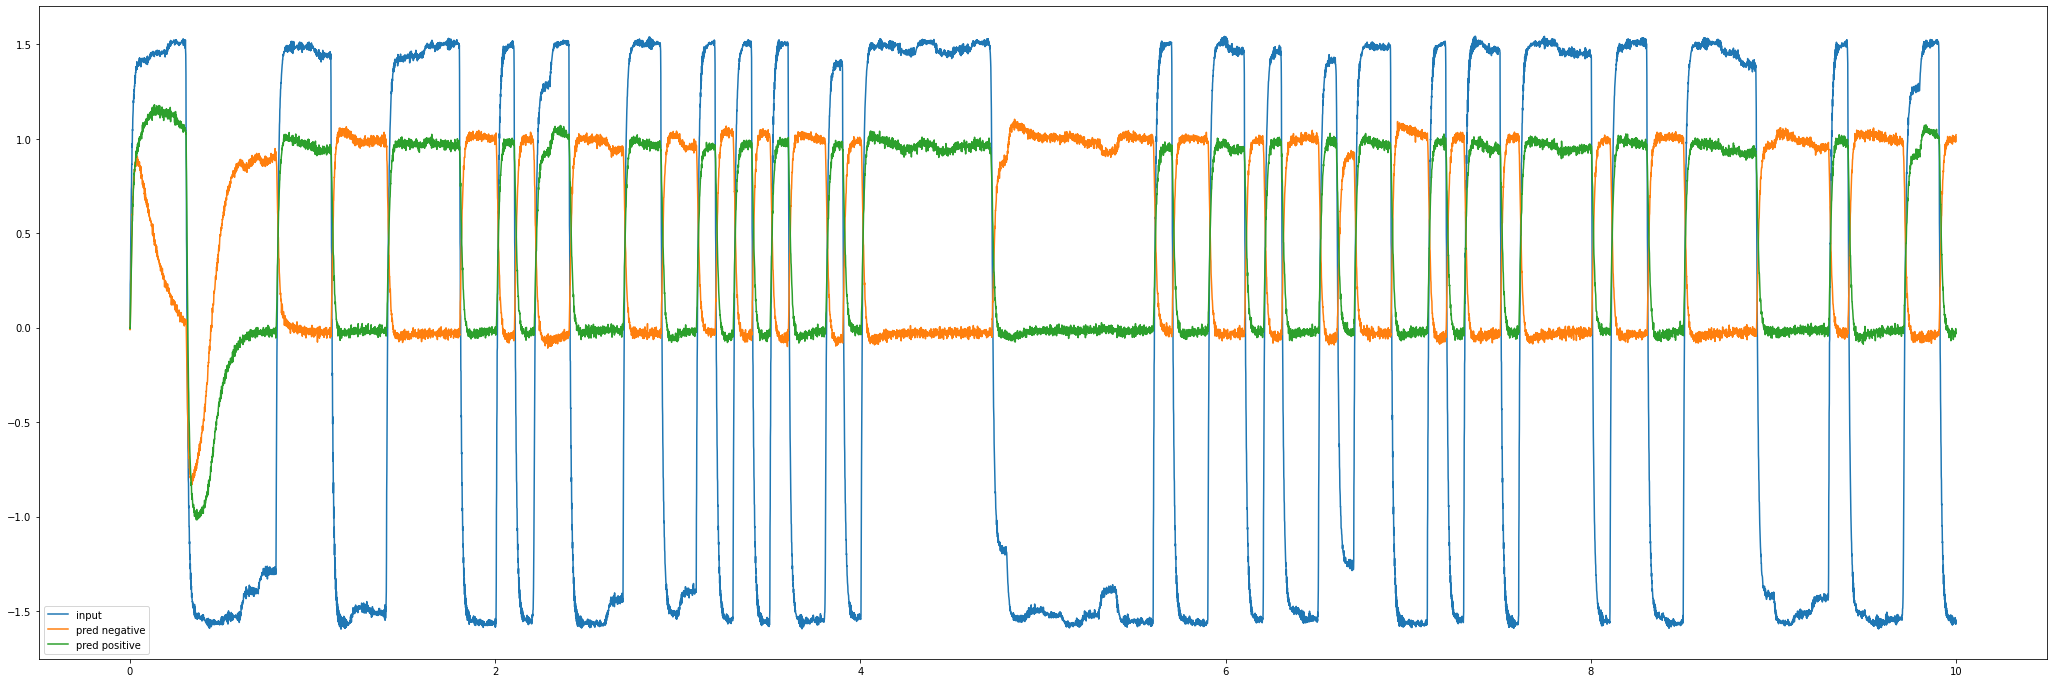

In [9]:
plt.figure(figsize=(36, 12))
plt.plot(sim.trange(), sim.data[input_p], label="input")
plt.plot(sim.trange(), sim.data[pred_p][:, 0], label="pred negative")
plt.plot(sim.trange(), sim.data[pred_p][:, 1], label="pred positive")
# plt.plot(sim.trange(), sim.data[target_p][:, 0], label="target negative")
# plt.plot(sim.trange(), sim.data[target_p][:, 1], label="target positive")
plt.legend()
plt.show()

# Test

In [10]:
x_data = np.random.uniform(-50, 50, 100)
y_data = np.eye(2)[(x_data>standard).astype(np.int32)]

dataset.set_dataset(x_data, y_data)

In [11]:
with nengo.Simulator(model) as sim:
    sim.run(10.0)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

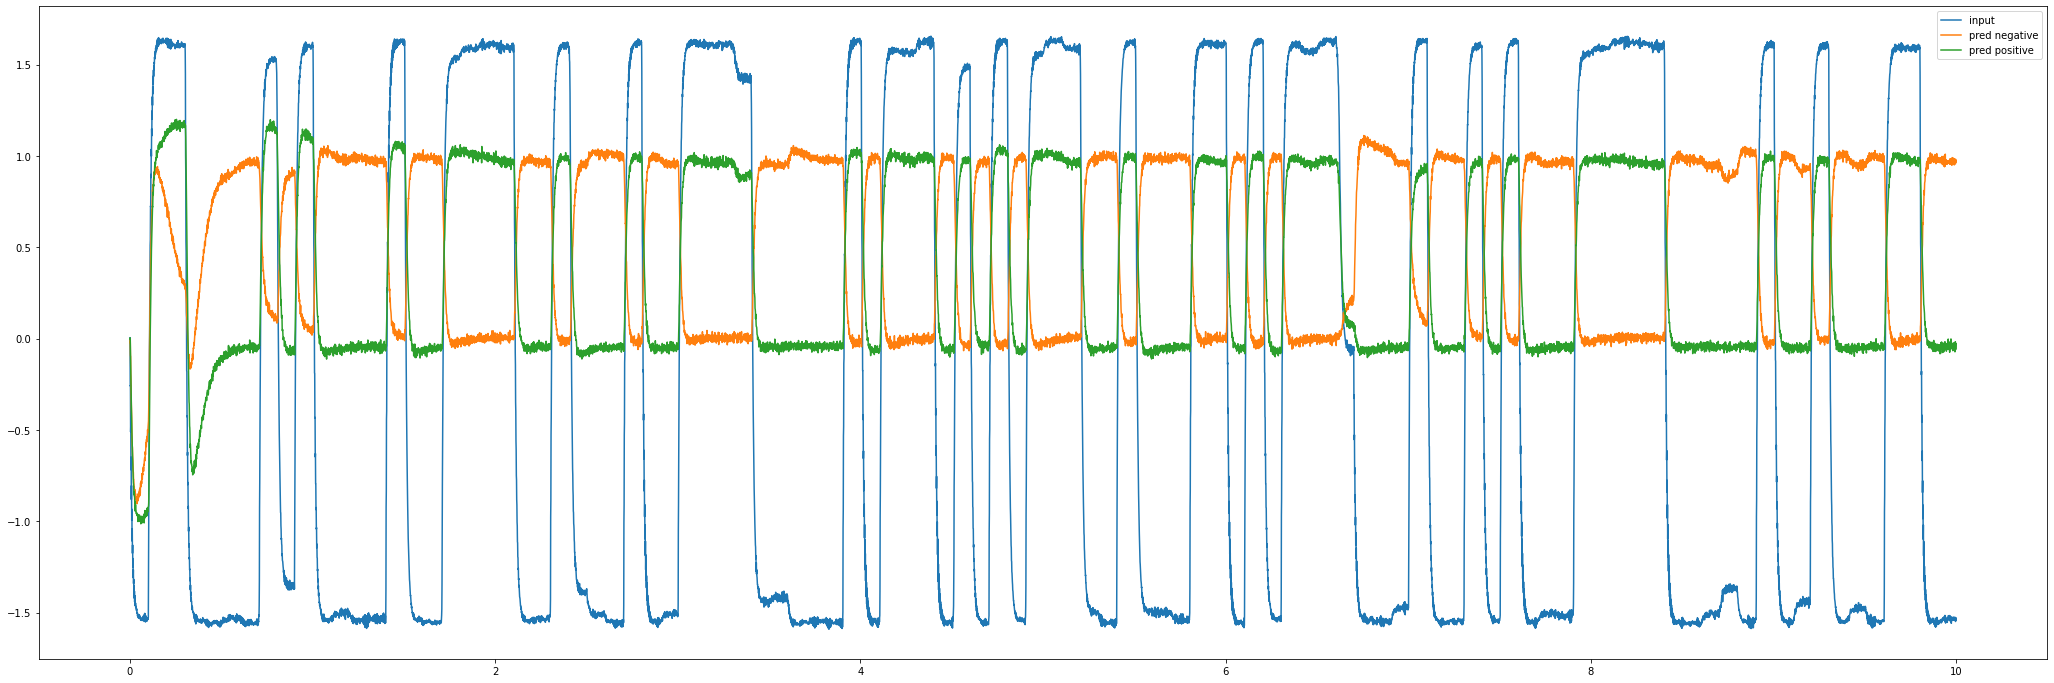

In [12]:
plt.figure(figsize=(36, 12))
plt.plot(sim.trange(), sim.data[input_p], label="input")
plt.plot(sim.trange(), sim.data[pred_p][:, 0], label="pred negative")
plt.plot(sim.trange(), sim.data[pred_p][:, 1], label="pred positive")
# plt.plot(sim.trange(), sim.data[target_p][:, 0], label="target negative")
# plt.plot(sim.trange(), sim.data[target_p][:, 1], label="target positive")
plt.legend()
plt.show()

In [13]:
sim.data[pred_p].argmax(-1).shape

preds = []
for i in range(0, 10000, 100):
  data = sim.data[pred_p][i:i+100]
  preds.append(data.mean(axis=0).argmax())

print(classification_report(y_data.argmax(-1), preds))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        57
           1       0.98      1.00      0.99        43

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100

